In [1]:
### Train a CNN model from image of crops and fields, and classify the two. Modified from the horticulture research paper
# The code should be run in the ./src folder with training data available

import glob
import os
from shutil import copyfile

from numpy.random import randint
from skimage.io import imread
# from skimage.color import rgb2gray, gray2rgb
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms

In [2]:
import pdb
def read_dataset():

    # Field: 0; Lettuce: 1
    train_dirs = ["./data/train/field/", "./data/train/lettuce/"]
    validation_dirs = ["./data/validation/field/", "./data/validation/lettuce/"]

    train_X = []
    train_Y = []
    class_num = 0
    for dirs in train_dirs:
        for file in glob.glob(dirs + "*.png"):
            tmp = imread(file)  # already gray scale
            train_X.append(tmp.reshape(1, 7, 8))
            train_Y.append(class_num)
        # pdb.set_trace()
        class_num += 1

    validation_X = []
    validation_Y = []
    class_num = 0
    for dirs in validation_dirs:
        for file in glob.glob(dirs + "*.png"):
            tmp = imread(file)
            validation_X.append(tmp.reshape(1, 7, 8))
            validation_Y.append(class_num)
        class_num += 1

    train_X = torch.tensor(np.array(train_X), dtype=torch.float32)
    train_Y = torch.tensor(train_Y, dtype=torch.long)
    train_Y = torch.nn.functional.one_hot(train_Y, num_classes=2).float()

    validation_X = torch.tensor(np.array(validation_X), dtype=torch.float32)
    validation_Y = torch.tensor(validation_Y, dtype=torch.long)
    validation_Y = torch.nn.functional.one_hot(validation_Y, num_classes=2).float()

    return train_X, train_Y, validation_X, validation_Y


In [3]:
class ConvModel1(nn.Module):
    def __init__(self, input_size=(1, 7 ,8), num_classes=2):
        
        super(ConvModel1, self).__init__()
        self.input_channel, self.height, self.width = input_size
        self.kernel_size = 3
        self.padding = (self.kernel_size - 1) // 2  # ensure input and output have the same size
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(self.input_channel, 32, kernel_size=self.kernel_size, padding=self.padding),
            nn.ReLU(),
            nn.BatchNorm2d(32),     
            nn.Conv2d(32, 32, kernel_size=self.kernel_size, padding=self.padding),
            nn.ReLU(),
            nn.BatchNorm2d(32),     
            # For pooling: output_size = ((input_size - kernel_size) / stride) + 1
            nn.MaxPool2d(kernel_size=(2, 2))  # default stride=2,
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=self.kernel_size, padding=self.padding),
            nn.ReLU(),
            nn.BatchNorm2d(64),     
            nn.Conv2d(64, 64, kernel_size=self.kernel_size, padding=self.padding),
            nn.ReLU(),
            nn.BatchNorm2d(64),     
            nn.MaxPool2d(kernel_size=(2, 2))  # default stride=2,
        )

        height_out = (((self.height - 2) // 2 + 1) - 2) // 2 + 1
        width_out = (((self.width - 2) // 2 + 1) - 2) // 2 + 1

        self.fc1 = nn.Linear(64 * height_out * width_out, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.fc1_batch_norm = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = nn.Flatten()(x)
        x = self.fc1_batch_norm(
                nn.ReLU()(
                    self.fc1(x)
                )
            )
        x = self.dropout(x)
        x = self.softmax(self.fc2(x))  # apply softmax along the 2nd dim, i.e., num_classes
        return x



In [10]:
def train_and_test(train_X, train_Y, validation_X, validation_Y, epochs=10):
    model_name = 'trained_model_new3.pth'

    # Create data loaders
    train_dataset = TensorDataset(train_X, train_Y)
    validation_dataset = TensorDataset(validation_X, validation_Y)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)

    # Create an instance of the CNN model
    model = ConvModel1(num_classes=2)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Original  optim.RMSprop(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels[:, 1]).sum().item()

        train_loss = running_loss/len(train_loader)
        train_accuracy = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f'Epoch {epoch+1}, Training loss: {train_loss}, Training accu: {train_accuracy}')

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels[:, 1]).sum().item()
        
        val_loss /= len(validation_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}, Validation loss: {val_loss}, Validation accu: {val_accuracy}')
        
        # Save the model checkpoint
        # torch.save(model.state_dict(), f'./epochs/{epoch+1:02d}-{val_loss:.2f}.pth')

        # If using early stopping, you can monitor val_loss and stop if it hasn't decreased for a certain number of epochs
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_name)

    return {'train_losses': train_losses, 
            'train_accuracies': train_accuracies, 
            'val_losses': val_losses, 
            'val_accuracies': val_accuracies,
    }

def plot_model(perf):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(perf['train_losses'], label='Train Loss')
    plt.plot(perf['val_losses'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    plt.subplot(1, 2, 2)
    plt.plot(perf['train_accuracies'], label='Train Accuracy')
    plt.plot(perf['val_accuracies'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')

    plt.show()

In [9]:

# Load your dataset
train_X, train_Y, validation_X, validation_Y = read_dataset()

In [13]:
perf = train_and_test(train_X, train_Y, validation_X, validation_Y, epochs=10)

Epoch 1, Training loss: 0.33516369503119897, Training accu: 0.978448275862069
Epoch 1, Validation loss: 0.313476935542863, Validation accu: 1.0
Epoch 2, Training loss: 0.3138008035462478, Training accu: 0.9994612068965517
Epoch 2, Validation loss: 0.31400762138695554, Validation accu: 0.9988864142538976
Epoch 3, Training loss: 0.3133009908528164, Training accu: 1.0
Epoch 3, Validation loss: 0.3133144039532234, Validation accu: 1.0
Epoch 4, Training loss: 0.31358777860115317, Training accu: 1.0
Epoch 4, Validation loss: 0.3132901993291131, Validation accu: 1.0
Epoch 5, Training loss: 0.31329188984015893, Training accu: 1.0
Epoch 5, Validation loss: 0.3133865337947319, Validation accu: 1.0
Epoch 6, Training loss: 0.3132833396566325, Training accu: 1.0
Epoch 6, Validation loss: 0.3132698977815694, Validation accu: 1.0
Epoch 7, Training loss: 0.31328343214659854, Training accu: 1.0
Epoch 7, Validation loss: 0.31353942792991113, Validation accu: 0.9994432071269488
Epoch 8, Training loss: 0.

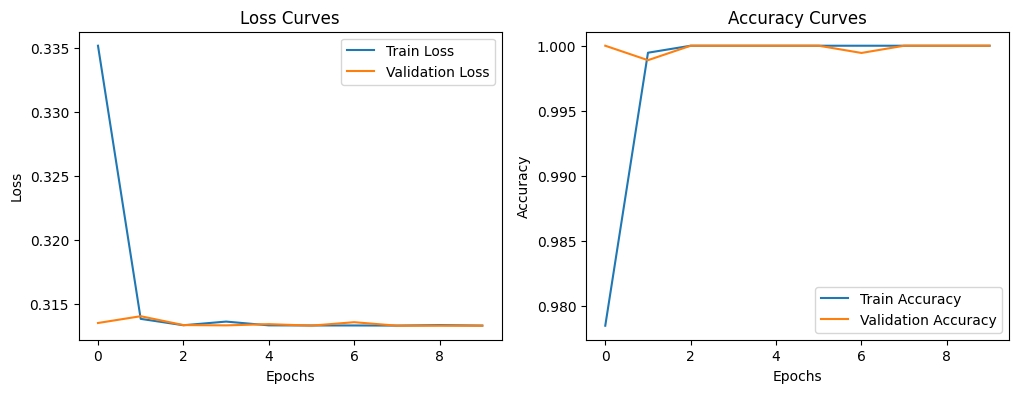

In [14]:
plot_model(perf)

In [7]:
# Backup
# data_iter = iter(train_loader)
# inputs, labels = next(data_iter)
# print(inputs.shape, labels.shape)
# layer1 = nn.Sequential(
#         nn.Conv2d(1, 32, kernel_size=3, padding=1),
#         nn.ReLU(),
#         nn.BatchNorm2d(32),     
#         # For pooling: output_size = ((input_size - kernel_size) / stride) + 1
#         nn.MaxPool2d(kernel_size=(2, 2))  # default stride=2,
#     )